Basé sur analysis_3d versio 0.14

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
from pathlib import Path
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
from gammapy.data import DataStore
from gammapy.irf import EnergyDispersion, make_mean_psf, make_mean_edisp
from gammapy.maps import WcsGeom, MapAxis, Map, WcsNDMap
from gammapy.cube import MapMaker, PSFKernel, MapDataset
from gammapy.modeling.models import (
    SkyModel,
    SkyDiffuseCube,
    BackgroundModel,
    PowerLawSpectralModel,
    ExpCutoffPowerLawSpectralModel,
    PointSpatialModel,
)
from gammapy.spectrum import FluxPointsEstimator
from gammapy.modeling import Fit

In [16]:
# Define which data to use and print some information
data_store = DataStore.from_dir("../data/ash_stereo_Prod17_Calib0834_thsq64")
data_store.info()

Data store:
HDU index table:
BASE_DIR: ../data/ash_stereo_Prod17_Calib0834_thsq64
Rows: 122853
OBS_ID: 18092 -- 151486
HDU_TYPE: ['aeff', 'bkg', 'edisp', 'events', 'gti', 'psf']
HDU_CLASS: ['aeff_2d', 'bkg_2d', 'edisp_2d', 'events', 'gti', 'psf_3gauss', 'psf_table']


Observation table:
Observatory name: 'N/A'
Number of observations: 20485



In [17]:
print(
    "Observation time (hours): ", data_store.obs_table["ONTIME"].sum() / 3600
)
print("Observation table: ", data_store.obs_table.colnames)
print("HDU table: ", data_store.hdu_table.colnames)

Observation time (hours):  9266.447777777777
Observation table:  ['AIRTEMP', 'ALT_PNT', 'AZ_PNT', 'BKG_SCALE', 'BROKPIX', 'DATE_END', 'DATE_OBS', 'DEADC', 'DEC_OBJ', 'DEC_PNT', 'EFFAREA_MAX', 'EFFAREA_RECO_MAX', 'EVENT_COUNT', 'EVENT_DEC_MEDIAN', 'EVENT_ENERGY_MEDIAN', 'EVENT_RA_MEDIAN', 'EVENT_TIME_MAX', 'EVENT_TIME_MIN', 'GLAT_PNT', 'GLON_PNT', 'HI_THRES', 'LIVETIME', 'LO_THRES', 'MUONEFF', 'NSBLEVEL', 'N_TELS', 'OBJECT', 'OBS_ID', 'ONTIME', 'PRESSURE', 'QUALITY', 'RA_OBJ', 'RA_PNT', 'RELHUM', 'TELLIST', 'TIME_END', 'TIME_OBS', 'TMID', 'TMID_STR', 'TRGRATE', 'TSTART', 'TSTART_STR', 'TSTOP', 'TSTOP_STR', 'ZEN_PNT', 'ZTRGRATE']
HDU table:  ['OBS_ID', 'HDU_TYPE', 'HDU_CLASS', 'FILE_DIR', 'FILE_NAME', 'HDU_NAME', 'SIZE', 'MTIME', 'MD5']


In [80]:
data_store.obs_table["OBS_ID",'GLAT_PNT', 'GLON_PNT', 'OBJECT'][190:210]

OBS_ID,GLAT_PNT,GLON_PNT,OBJECT
,deg,deg,
int64,float32,float32,bytes43
20299,18.921936,309.4433,Cen A
20300,19.912144,309.59134,Cen A
20301,-0.8857012,320.56754,MSH 15-5-02
20302,-1.7397733,320.04724,MSH 15-5-02
20303,-0.8857012,320.56754,MSH 15-5-02
20304,-1.7397733,320.04724,MSH 15-5-02
20307,-0.06223724,347.8998,RXJ 1713.7-3946
20311,67.177925,226.77802,RGB J1117+202


In [31]:
# une formule simple pour lire l'objet observé lors d'une observation donnée
data_store.obs(151486).obs_info['OBJECT']

'ToO AT2019krl'

In [34]:
%%time
ids = list(data_store.obs_table['OBS_ID'])
ids_crab = []

for k in ids :
    if data_store.obs(k).obs_info['OBJECT'] == 'Crab Nebula':
        ids_crab.append(k)

print(ids_crab)

[18406, 18410, 18415, 18478, 18480, 18517, 18526, 18529, 18561, 18564, 18565, 18566, 18598, 18599, 18870, 18871, 18873, 18874, 18875, 18885, 18886, 18887, 18888, 18889, 18890, 18927, 18942, 18943, 18945, 18946, 23037, 23063, 23309, 23310, 23523, 23526, 23544, 23545, 23546, 23547, 23555, 23556, 23557, 23558, 23559, 23562, 23576, 23577, 23578, 23579, 23592, 23593, 23594, 23608, 23610, 23641, 23642, 23662, 23663, 23739, 23740, 23741, 23753, 23754, 23756, 24138, 24139, 24140, 24141, 29873, 29874, 35941, 35956, 35957, 35992, 36012, 36013, 36066, 43038, 43039, 43424, 43447, 43489, 43490, 48399, 48476, 48682, 48683, 48717, 48750, 54390, 54391, 54392, 54404, 54623, 54624, 54653, 54706, 54707, 54734, 54735, 54748, 54749, 54771, 54772, 54789, 54809, 60793, 60794, 60795, 80026, 80081, 80084, 80086, 80124, 80129, 80132, 80134, 80154, 80158, 80161, 80163, 80165, 80167, 80170, 80190, 80191, 80996, 80997, 80998, 81022, 81023, 81078, 81083, 81086, 81089, 81133, 81134, 81135, 81136, 81160, 81664, 81666

In [78]:
%%time
ids = list(data_store.obs_table['OBS_ID'])
ids_sgrA = []

for k in ids :
    if data_store.obs(k).obs_info['OBJECT'] == 'Sgr A':
        ids_sgrA.append(k)

print(ids_sgrA)

[20191, 20192, 20193, 20194, 20195, 20198, 20199]
CPU times: user 40.3 s, sys: 138 ms, total: 40.4 s
Wall time: 40.5 s


In [81]:
%%time
ids = list(data_store.obs_table['OBS_ID'])
ids_gc = []

for k in ids :
    if data_store.obs(k).obs_info['OBJECT'] == 'Sgr A*':
        ids_gc.append(k)

print(ids_gc)

[20549, 20550, 20551, 20552, 20553, 20554, 20567, 20568, 20572, 20573, 20580, 20581, 20582, 20583, 20584, 20596, 20597, 20598, 20608, 20609, 20922, 20923, 20924, 20925, 20929, 20930, 20967, 20968, 20998, 20999, 21006, 21007, 21016, 21017, 21027, 21028, 21146, 21147, 21148, 21149, 21165, 21166, 21167, 21168, 21245, 21275, 21276, 21347, 21348, 21349, 21350, 21372, 21373, 21376, 21377, 21389, 21390, 21411, 21452, 21453, 21463, 21464, 21486, 21491, 21492, 21493, 21494, 21496, 21497, 21508, 21862, 21863, 21872, 21873, 21874, 21876, 21877, 21894, 21895, 21896, 21897, 21909, 21910, 22258, 25330, 25331, 25349, 25350, 25353, 25379, 25380, 25401, 25402, 25403, 25404, 25405, 25709, 26078, 26079, 26080, 26081, 26082, 26083, 26084, 26085, 26086, 26087, 26088, 26089, 26090, 26091, 26104, 26105, 26106, 26107, 26108, 26109, 26110, 26111, 26112, 26113, 26114, 26115, 26116, 26789, 26790, 26810, 26811, 26812, 26813, 27375, 27376, 27377, 27378, 27498, 27499, 27500, 27501, 27502, 27503, 27504, 27505, 27506

In [82]:
len(ids_gc)

642

In [38]:
obs_ids = ids_crab[:10]
observations = data_store.get_observations(obs_ids)

In [44]:
obs_ids

[18406, 18410, 18415, 18478, 18480, 18517, 18526, 18529, 18561, 18564]

In [39]:
energy_axis = MapAxis.from_edges(
    np.logspace(-1.0, 1.0, 10), unit="TeV", name="energy", interp="log")

geom = WcsGeom.create(
    skydir=(184.55, -5.78),
    binsz=0.02,
    width=(10, 8),
    coordsys="GAL",
    proj="CAR",
    axes=[energy_axis],
)

In [47]:
data_store.obs(18406).obs_info

{'AIRTEMP': <Quantity 18.72652 degC>,
 'ALT_PNT': <Quantity 44.287304 deg>,
 'AZ_PNT': <Quantity 7.8426003 deg>,
 'BKG_SCALE': -1.0,
 'BROKPIX': 0.00625,
 'DATE_END': '2004-01-21',
 'DATE_OBS': '2004-01-21',
 'DEADC': 0.9102752,
 'DEC_OBJ': <Quantity 22.014444 deg>,
 'DEC_PNT': <Quantity 24.514444 deg>,
 'EFFAREA_MAX': 757132.125,
 'EFFAREA_RECO_MAX': -1.0,
 'EVENT_COUNT': 3841,
 'EVENT_DEC_MEDIAN': <Quantity 24.3562 deg>,
 'EVENT_ENERGY_MEDIAN': <Quantity 0.77718186 TeV>,
 'EVENT_RA_MEDIAN': <Quantity 83.63389 deg>,
 'EVENT_TIME_MAX': <Quantity 96408975.29531717 s>,
 'EVENT_TIME_MIN': <Quantity 96407389.1927545 s>,
 'GLAT_PNT': <Quantity -4.442268 deg>,
 'GLON_PNT': <Quantity 182.4398 deg>,
 'HI_THRES': 150,
 'LIVETIME': <Quantity 1443.6965 s>,
 'LO_THRES': -1,
 'MUONEFF': 0.87053204,
 'NSBLEVEL': 263140400.0,
 'N_TELS': 4,
 'OBJECT': 'Crab Nebula',
 'OBS_ID': 18406,
 'ONTIME': <Quantity 1586. s>,
 'PRESSURE': <Quantity 819.017 hPa>,
 'QUALITY': 0,
 'RA_OBJ': <Quantity 83.63333 deg>,


In [40]:
%%time
maker = MapMaker(geom, offset_max=4.0 * u.deg)
maps = maker.run(observations)

CPU times: user 1min 11s, sys: 18 s, total: 1min 29s
Wall time: 1min 30s


In [41]:
print(maps)

{'counts': WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'energy']
	shape : (500, 400, 9)
	ndim  : 3
	unit  : 
	dtype : float32
, 'exposure': WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'energy']
	shape : (500, 400, 9)
	ndim  : 3
	unit  : m2 s
	dtype : float32
, 'background': WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'energy']
	shape : (500, 400, 9)
	ndim  : 3
	unit  : 
	dtype : float64
}


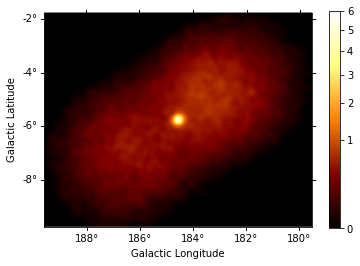

In [49]:
counts = maps["counts"].sum_over_axes()
counts.smooth(width=0.1 * u.deg).plot(stretch="sqrt", add_cbar=True, vmax=6);

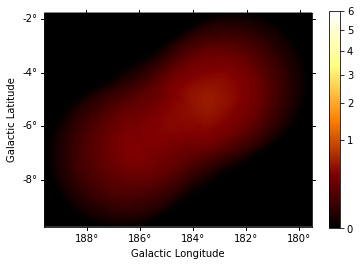

In [50]:
background = maps["background"].sum_over_axes()
background.smooth(width=0.1 * u.deg).plot(
    stretch="sqrt", add_cbar=True, vmax=6
);

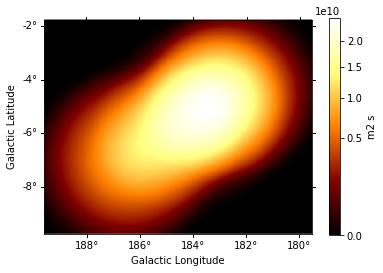

In [51]:
exposure = maps["exposure"].sum_over_axes()
exposure.smooth(width=0.1 * u.deg).plot(stretch="sqrt", add_cbar=True);

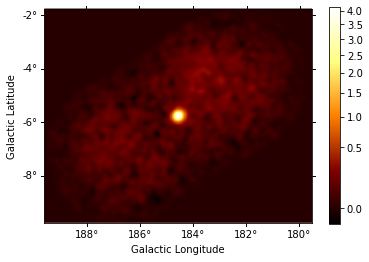

In [52]:
excess = counts - background
excess.smooth(5).plot(stretch="sqrt", add_cbar=True);

Si on étudiait le GC, on pourrait rajouter un modèle de l'émission diffuse à ce moment là, mais pour la nébuleuse du Crabe c'est pas la peine

Les IRF

In [53]:
# mean PSF
src_pos = SkyCoord(184.55, -5.78, unit="deg", frame="galactic")
table_psf = make_mean_psf(observations, src_pos)

# PSF kernel used for the model convolution
psf_kernel = PSFKernel.from_table_psf(table_psf, geom, max_radius="0.3 deg")

In [54]:
# define energy grid
energy = energy_axis.edges

# mean edisp
edisp = make_mean_edisp(
    observations, position=src_pos, e_true=energy, e_reco=energy
)

In [55]:
path = Path("analysis_3d")
path.mkdir(exist_ok=True)

In [57]:
# write maps
maps["counts"].write(str(path / "counts.fits"), overwrite=True)
maps["background"].write(str(path / "background.fits"), overwrite=True)
maps["exposure"].write(str(path / "exposure.fits"), overwrite=True)

# write IRFs
psf_kernel.write(str(path / "psf.fits"), overwrite=True)
edisp.write(str(path / "edisp.fits"), overwrite=True)

In [58]:
# read maps
maps = {
    "counts": Map.read(str(path / "counts.fits")),
    "background": Map.read(str(path / "background.fits")),
    "exposure": Map.read(str(path / "exposure.fits")),
}

# read IRFs
psf_kernel = PSFKernel.read(str(path / "psf.fits"))
edisp = EnergyDispersion.read(str(path / "edisp.fits"))

In [59]:
coords = maps["counts"].geom.get_coord()
mask = coords["energy"] > 0.3 * u.TeV

In [60]:
spatial_model = PointSpatialModel(
    lon_0="184.55 deg", lat_0="-5.78 deg", frame="galactic"
)
spectral_model = PowerLawSpectralModel(
    index=2.2, amplitude="3e-12 cm-2 s-1 TeV-1", reference="1 TeV"
)
model = SkyModel(spatial_model=spatial_model, spectral_model=spectral_model)

In [61]:
background_model = BackgroundModel(maps["background"], norm=1.1, tilt=0.0)
background_model.parameters["norm"].frozen = False
background_model.parameters["tilt"].frozen = True

In [62]:
dataset = MapDataset(
    model=model,
    counts=maps["counts"],
    exposure=maps["exposure"],
    background_model=background_model,
    mask_fit=mask,
    psf=psf_kernel,
    edisp=edisp,
)

In [63]:
%%time
fit = Fit(dataset)
result = fit.run(optimize_opts={"print_level": 1})

RuntimeError: exception was raised in user function
User function arguments:
        par_000_lon_0 = +2.080227
        par_001_lat_0 = -5.780000
        par_002_index = +2.200000
    par_003_amplitude = +3.000000
         par_004_norm = +1.100000
Original python exception in user function:
ValueError: Position <SkyCoord (Galactic): (l, b) in deg
    (208.02271117, -5.78)> of model component is outside the image boundaries. Please check the starting values or position parameter boundaries of the model.
  File "/Users/user/anaconda3/envs/gammapy-0.14/lib/python3.7/site-packages/gammapy/modeling/iminuit.py", line 17, in fcn
    return self.function()
  File "/Users/user/anaconda3/envs/gammapy-0.14/lib/python3.7/site-packages/gammapy/modeling/datasets.py", line 132, in likelihood
    total_likelihood += dataset.likelihood()
  File "/Users/user/anaconda3/envs/gammapy-0.14/lib/python3.7/site-packages/gammapy/cube/fit.py", line 515, in likelihood
    counts, npred = self._counts_data, self.npred().data
  File "/Users/user/anaconda3/envs/gammapy-0.14/lib/python3.7/site-packages/gammapy/cube/fit.py", line 275, in npred
    evaluator.update(self.exposure, self.psf, self.edisp, self._geom)
  File "/Users/user/anaconda3/envs/gammapy-0.14/lib/python3.7/site-packages/gammapy/cube/fit.py", line 851, in update
    f"Position {self.model.position!r} of model component is outside the image boundaries."
